# Example Notebook for Model Training

## Purpose
Show users how to use `model_utils` module for model evaluation and saving model artifacts. 

## Outline: 
1. Create synthetic data and train model against it
2. Use `plotting` module to evaluate model performance
3. Use `ModelConfig` to save the model artifact

# 1. Create synthetic data and train toy model

In [1]:
import pandas as pd 
import numpy as np 
from xgboost import XGBClassifier 
from numpy import random 
import matplotlib.pyplot as plt 
import boto3 
import sys  

from model_utils.training.plotting import ( 
    plot_xgb_training_curves,
    plot_feature_importance, 
    plot_roc, 
    plot_precision_recall, 
    plot_reliability, 
)
from model_utils.model_config import ModelConfig 

sample_size = int(10e4) 
prevalence = 0.5 
objective = "binary:logistic"
AUTHOR_EMAIL = "paul.atreides@*company-data-covered*.com"

In [2]:
def create_features(n): 
    data = {}
    data["patient_age"] = random.triangular(0, 50, 100, size=n).astype("int")
    data["risk_score"] = random.uniform(0, 20, size=n) 
    for i in range(30): 
        data[f"sdoh_score_{i}"] = random.uniform(0, 1, size=n) 
    return pd.DataFrame(data)

def sigmoid(x, center):
  return 1 / (1 + np.exp(center-x))

def create_labels(feat, n): 
    y_raw = sigmoid(feat["patient_age"], center=50) - sigmoid(feat["risk_score"], center=10) + np.random.normal(0, 0.1, size=n)
    return np.where(y_raw<0, 0, 1)

def train_model(x, y, objective): 
    model = XGBClassifier(n_estimators=10, random_state=123, objective=objective)
    model.fit(x, y, eval_set=[(x, y)]) 
    return model 

In [3]:
x_train = create_features(sample_size)
y_train = create_labels(x_train, sample_size)

x_valid = create_features(sample_size)
y_valid = create_labels(x_valid, sample_size) 

model = train_model(x_train, y_train, objective)

[0]	validation_0-logloss:0.53031
[1]	validation_0-logloss:0.44046
[2]	validation_0-logloss:0.38409
[3]	validation_0-logloss:0.34660
[4]	validation_0-logloss:0.32072
[5]	validation_0-logloss:0.30256
[6]	validation_0-logloss:0.28962
[7]	validation_0-logloss:0.28015
[8]	validation_0-logloss:0.27322
[9]	validation_0-logloss:0.26804


# 2. Use plotting module to evaluate performance

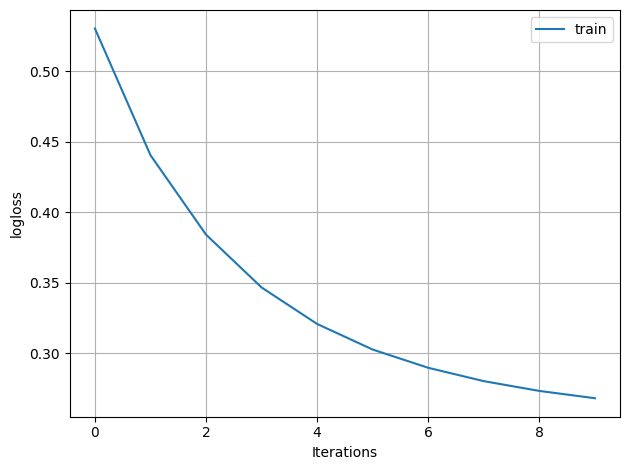

In [4]:
fig = plot_xgb_training_curves(model, metric='logloss', names = {"validation_0": "train"})
plt.show(fig)

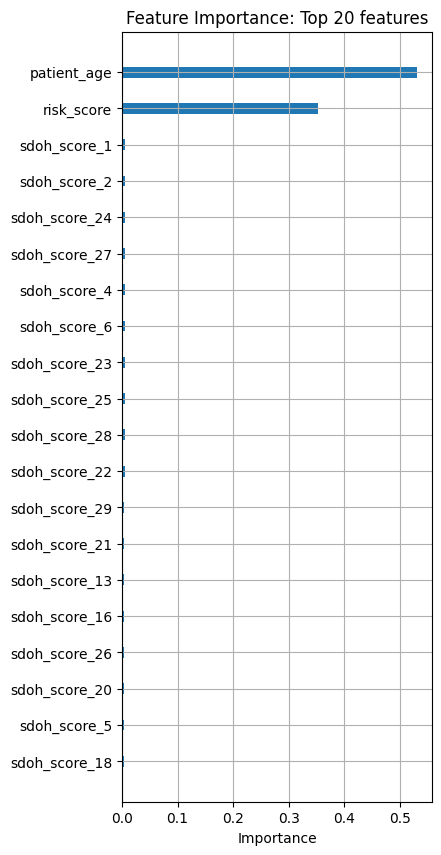

In [5]:
feat_names = ["patient_age", "risk_score"] + [f"sdoh_score_{i}" for i in range(30)]
fig = plot_feature_importance(model, feat_names)
plt.show(fig)

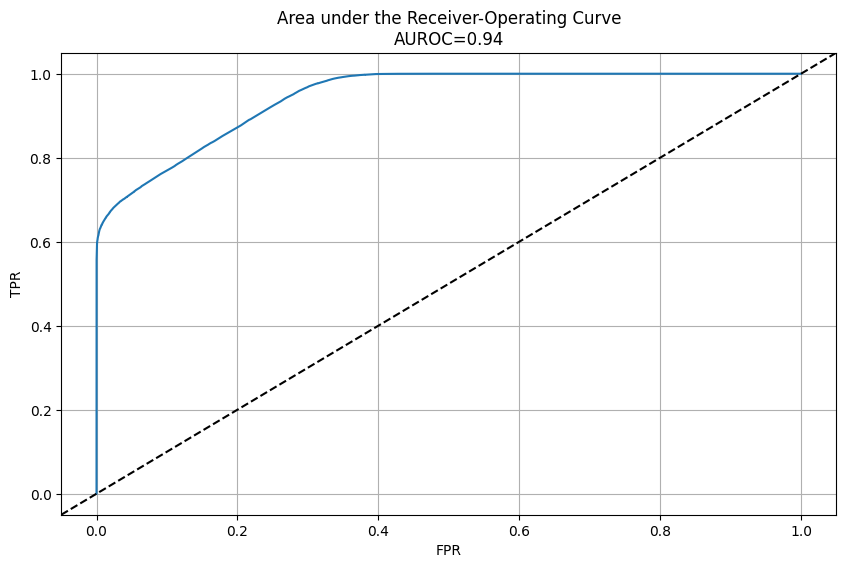

In [16]:
fig = plot_roc(model, x_valid, y_valid)
plt.show(fig)

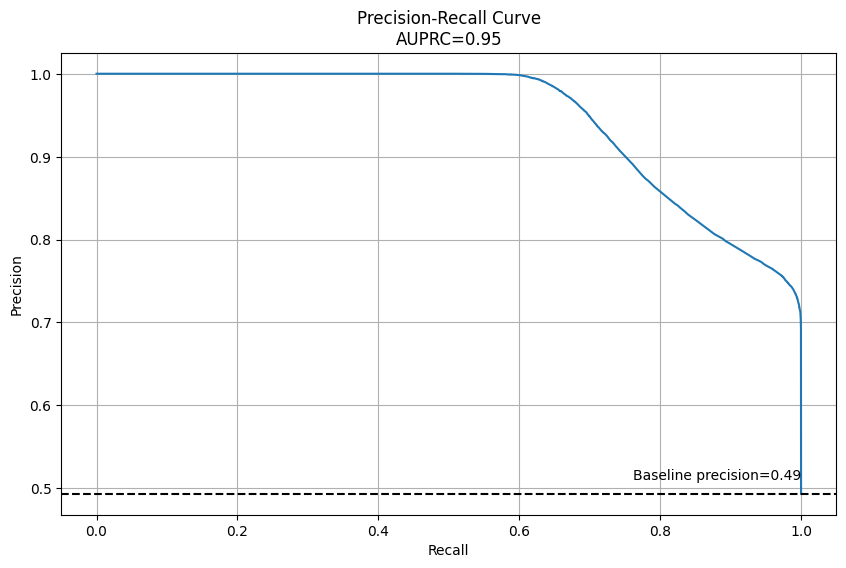

In [17]:
fig = plot_precision_recall(model, x_valid, y_valid)
plt.show(fig)

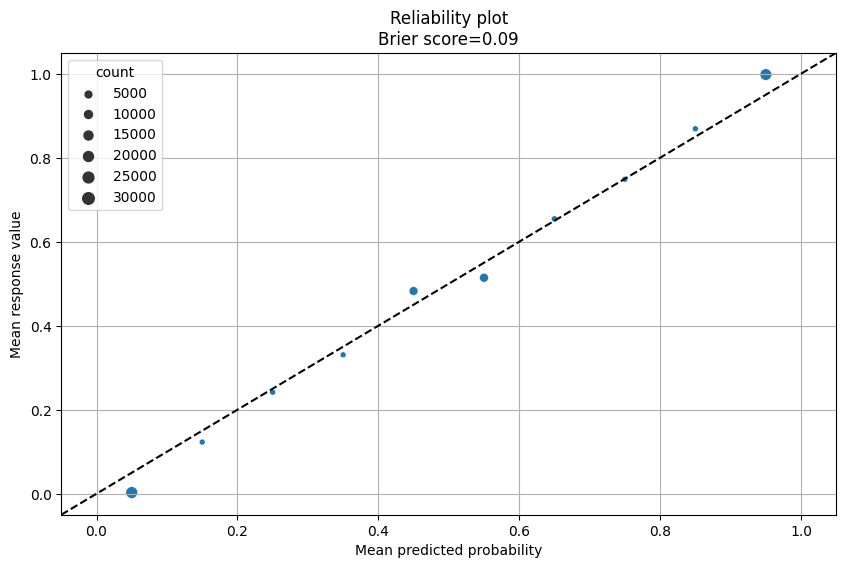

In [18]:
fig = plot_reliability(model, x_valid, y_valid)
plt.show(fig)

# 3. Use ModelConfig to save model artifact
Assume we earlier used ColumnTransformer `trans` to convert `x_train` and `x_valid` into CSR matrices

In [19]:
# # CELL NOT RUN 
# Use MFA to access model registry bucket
# session = boto3.Session(profile_name="mfa")
# s3 = session.client("s3")
# sys.path.append("../../normalized_protocol_names/") 
# from normalized_protocol_names.api import NormalizedProtocolNames 
# names = NormalizedProtocolNames(s3)
# RP_VERSION = names.get_latest_version()

# model_config = ModelConfig( 
#     model_name="toy",
#     model=model, 
#     training_set=(x_train, y_train), 
#     test_set=(x_valid, y_valid), 
#     column_transformer=trans, 
#     risk_protocol_mapping_version = RP_VERSION
#     author_email=AUTHOR_EMAIL
# )

In [20]:
# Save model to S3 
# model_config.save_to_model_registry(
#     s3 = s3
# )